<b><font color='purple' size="10">TP de Machine Learning : H4243 : ALPOU Yannick BAILLEUX Henri MOUSSET Maxime TABAKH Khalil</font> </b>

<b><font color='black' size="5">Nous avons pour ce TP mis en place des méthodes de Machine Learning pour prédire la qualité du vin grâce à un dataset de vins avec leur caractéristiques chimiques. Nous avons mis en place nous-même certaines méthodes et utilisé des bilibothèques pour d'autres.</font> </b>

<b><font color='red' size="10">1) La Régression Linéaire</font> </b>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('WineQT.csv')

<b><font color='blue' size="6">a) Visualisation et préparation des données</font> </b>

<b><font color='black' size="5">Nous commençons par une étape de visualisation des données. Cette étape nous permet de voir la distribution des différentes caractéristiques des vins.
</font> </b>

In [2]:
def plot_hists(df):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    for n in range(12):
        i = n % 3
        j = n % 4
        ax[i, j].hist(df.iloc[:, n], bins='auto')
        ax[i, j].set_xlabel(df.columns[n])

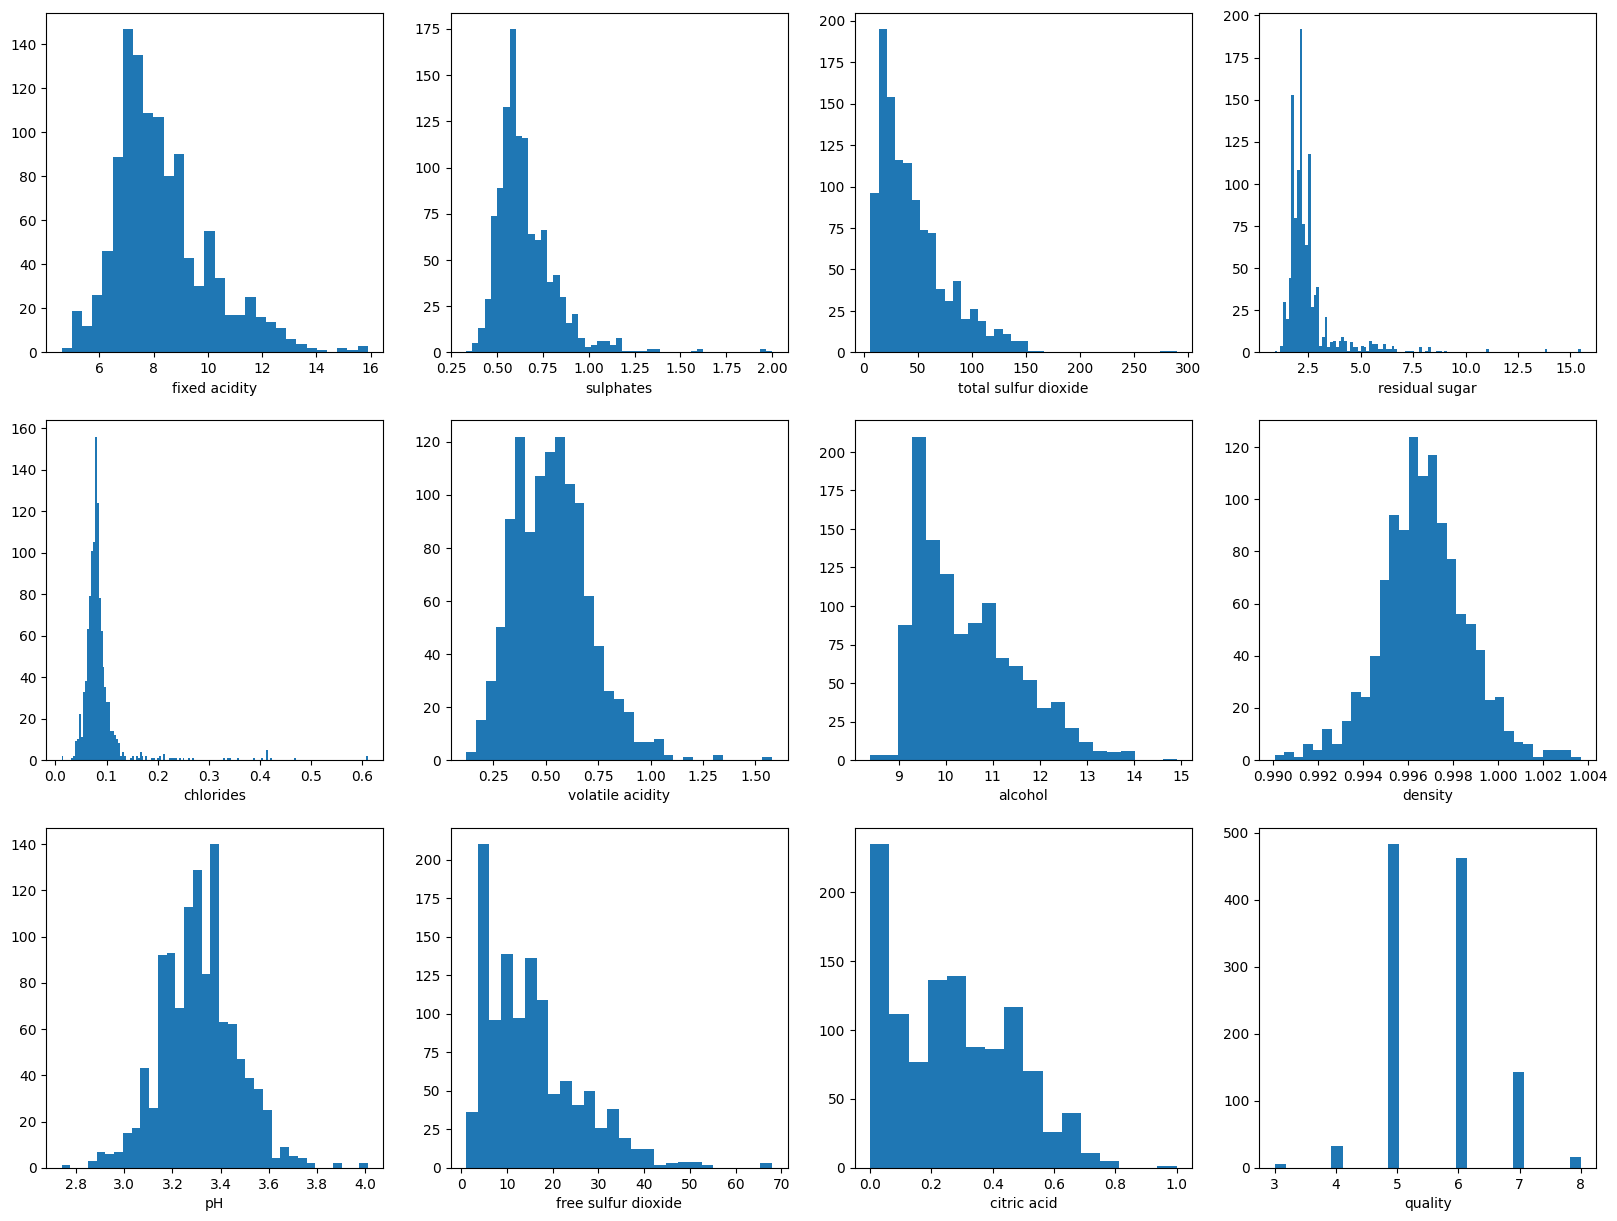

In [3]:
plot_hists(df)

<b><font color='black' size="5">Grâce à cette visualisation, nous modifions les colonnes qui ne semblent pas avoir une distribution normale.
On normalise avec un paramètre trouvé à la main pour chaque caractéristique et on standardise. Ci-dessous le résultat avant/après.</font> </b>

/home/henri/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


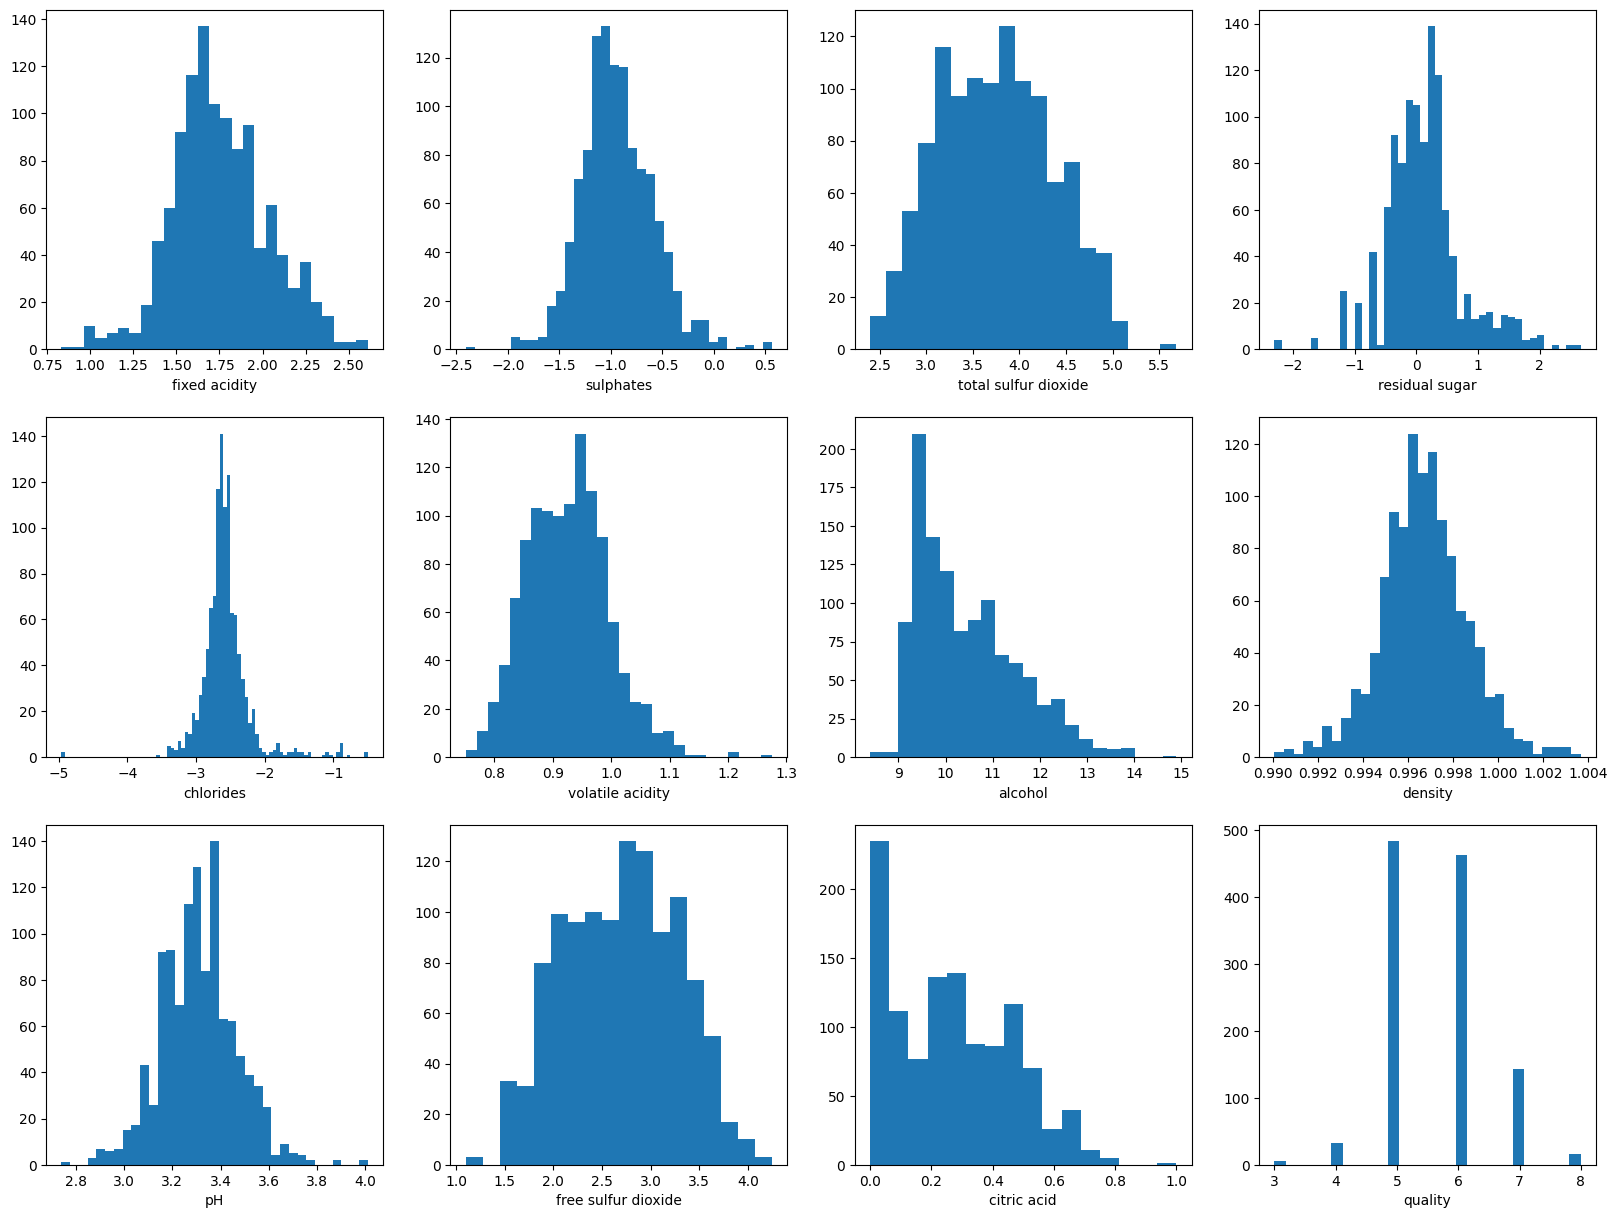

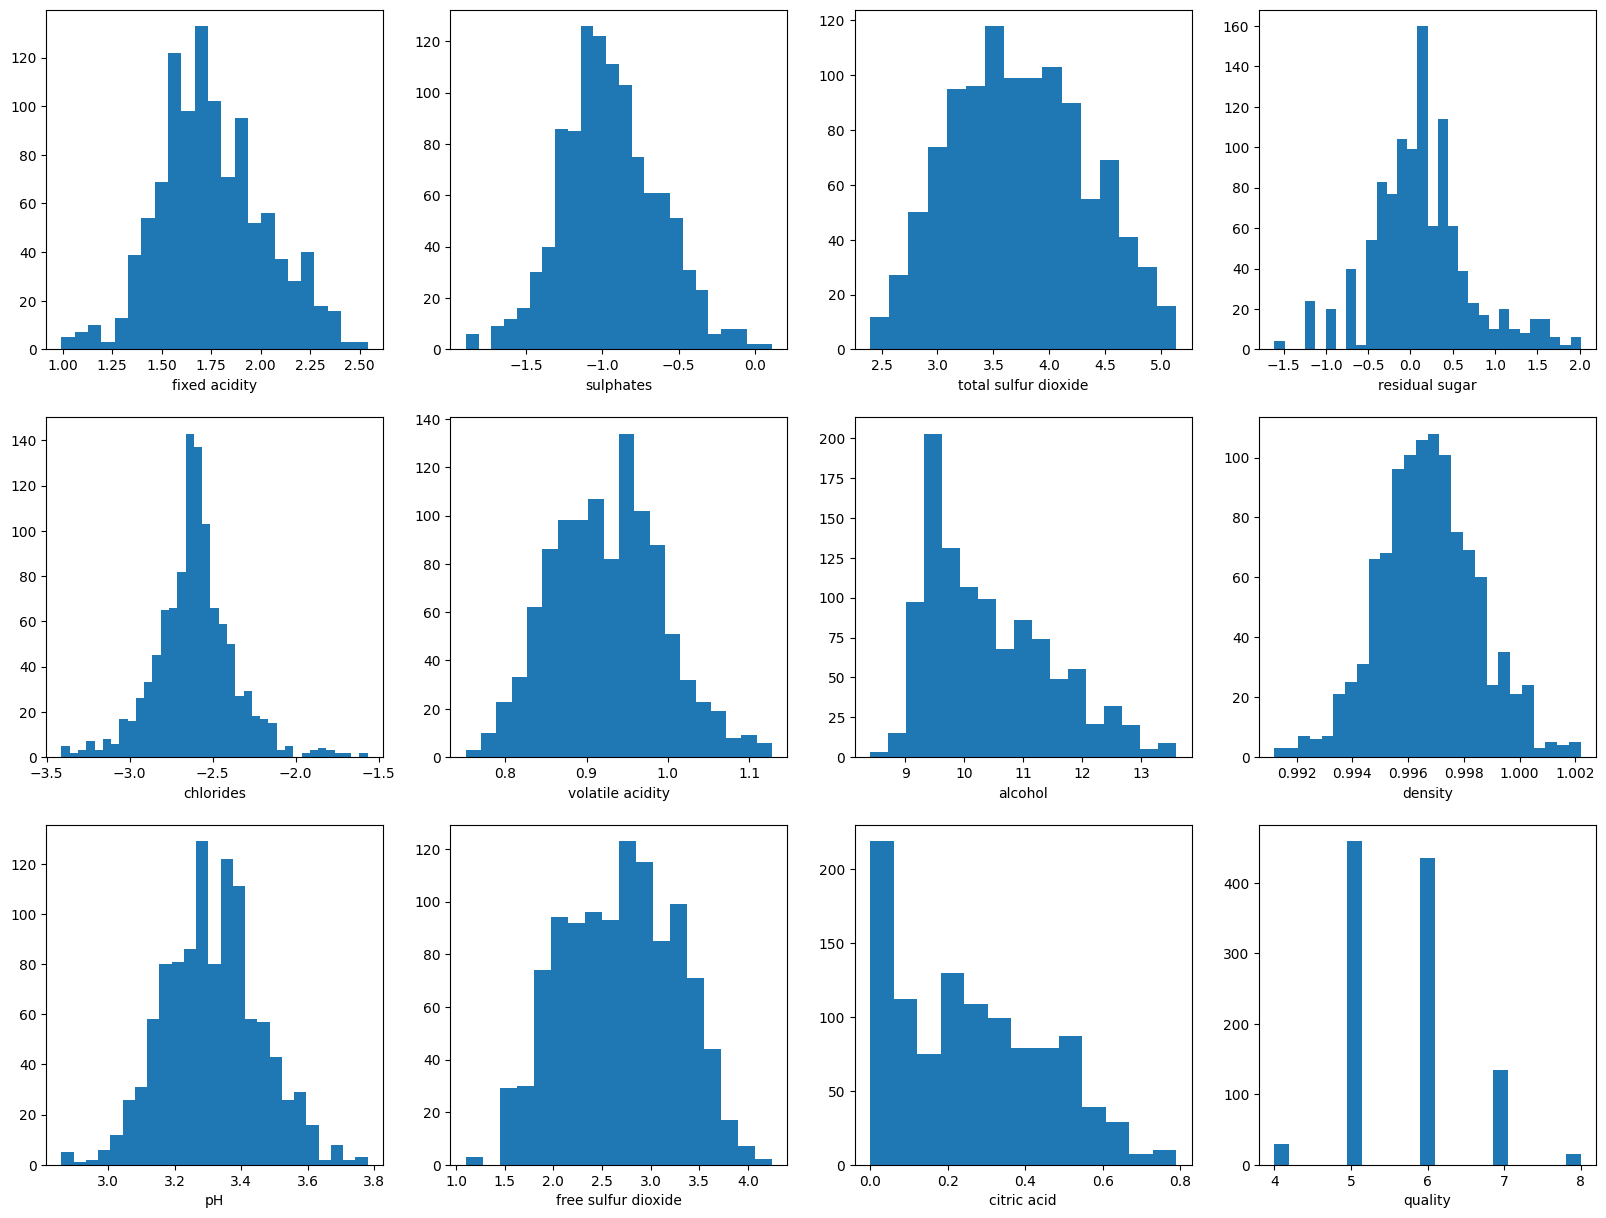

In [4]:
#mettre entre 0 et 1
def normalize(df, property, parameter):
    df[property] = np.log(df[property] + parameter)

normalize(df, "fixed acidity", -2.3)
normalize(df, "sulphates", -0.24)
normalize(df, "total sulfur dioxide", 5)
normalize(df, "residual sugar", -1.1)
normalize(df, "chlorides", -0.005)
normalize(df, "volatile acidity", 2)
normalize(df, "free sulfur dioxide", 2)
plot_hists(df)

#On enlève les observations anormales
standardized = (df - df.mean()) / df.std()
standardized = standardized[(np.abs(standardized) < 3).all(axis=1)]
rows = np.setdiff1d(list(df.index), list(standardized.index))
df.drop(index=rows, inplace=True)
plot_hists(df)

<b><font color='black' size="5">Souhaitant prédire la qualité, nous allons afficher les graphes des différentes caractéristiques en fonction de la qualité, ainsi qu'une matrice de corrélation linéaire.</font> </b>

<Axes: >

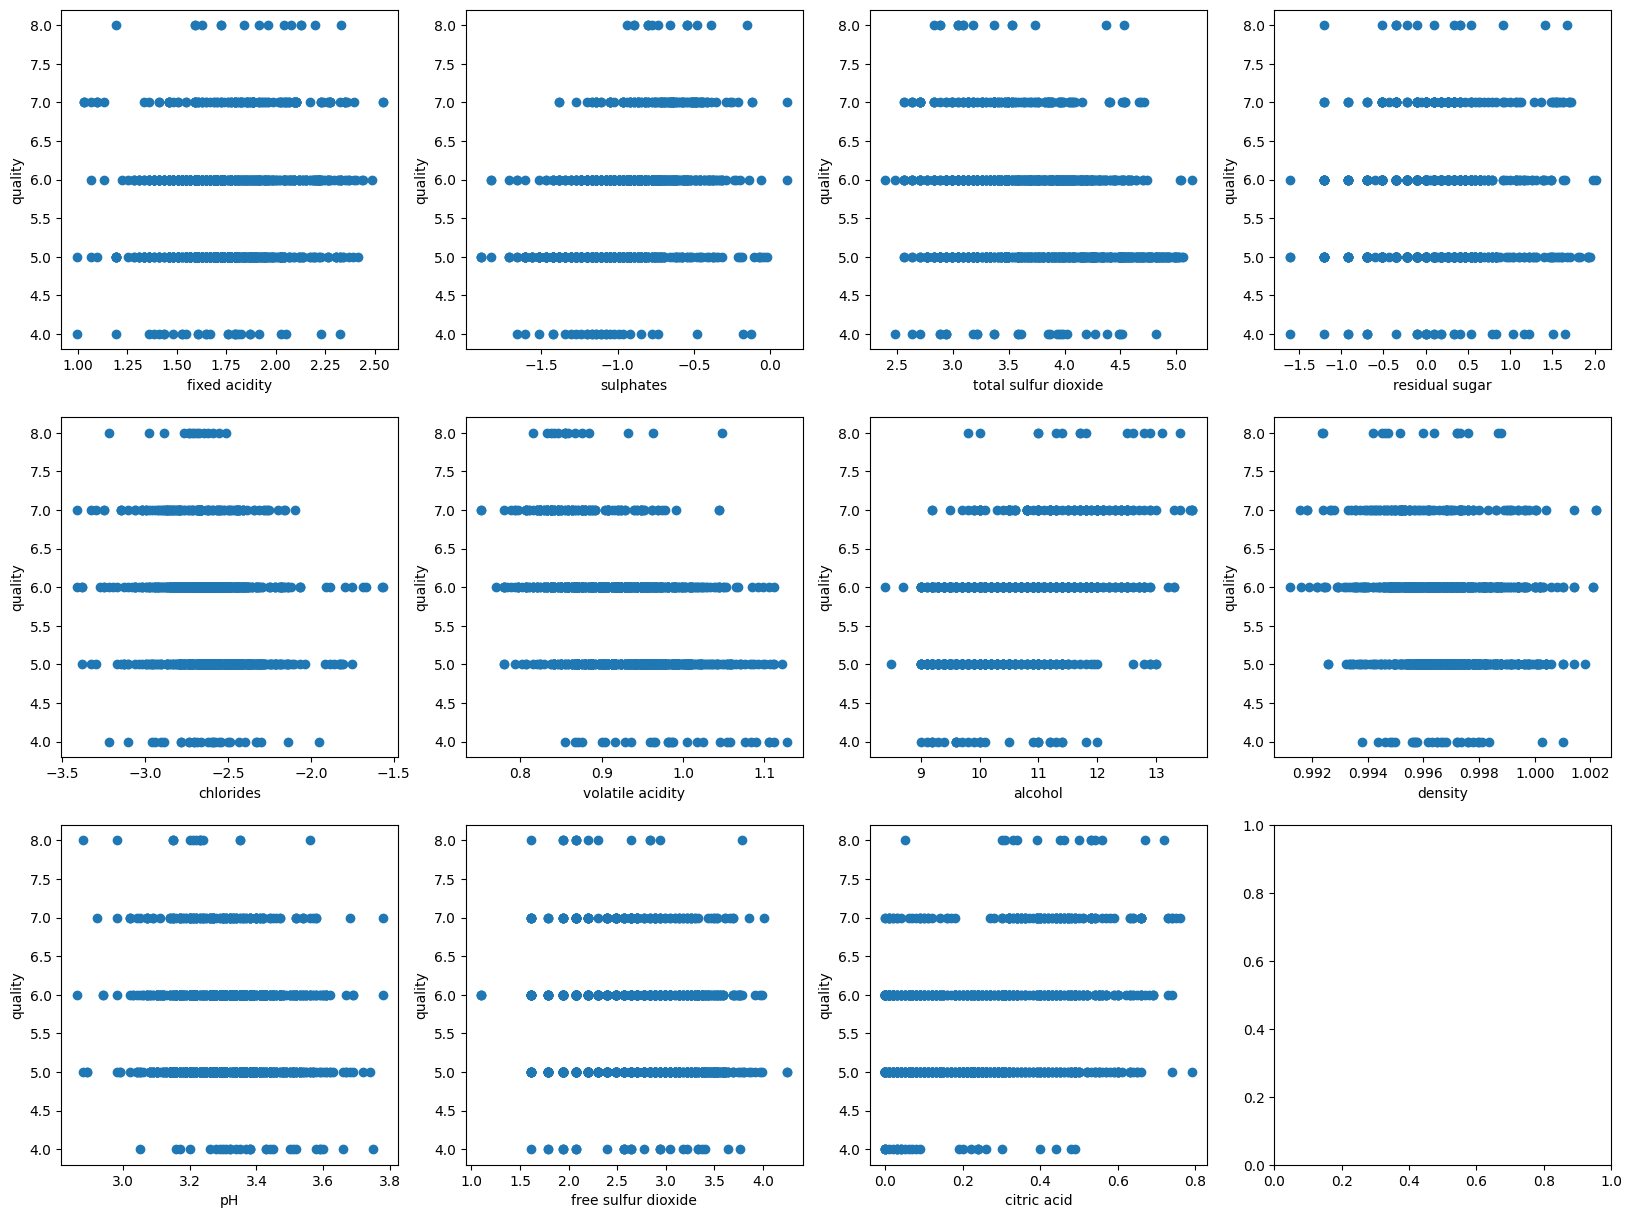

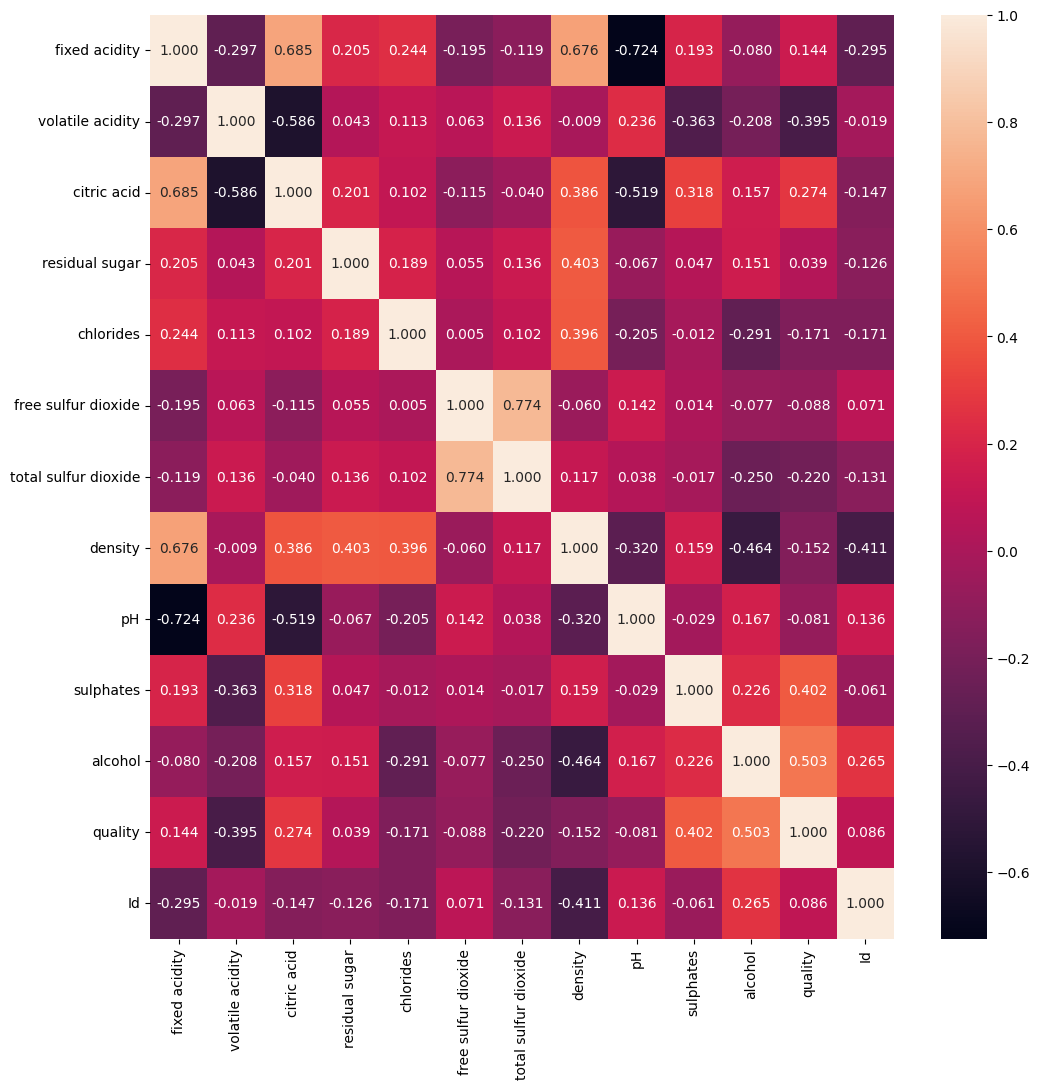

In [5]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
for n in range(11):
    i = n % 3
    j = n % 4
    ax[i, j].scatter(df.iloc[:, n], df['quality'])
    ax[i, j].set_xlabel(df.columns[n])
    ax[i, j].set_ylabel('quality')

import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
correlation = df.corr()
sns.heatmap(correlation, annot=True, fmt='.3f')

<b><font color='black' size="5">Certaines caractéristiques sont particulièrement corrélées. Mais on ne détecte rien de très intéressant pour la qualité. Le coefficient R ne dépassant jamais 0.5, on va garder toutes les données et continuer.</font> </b>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
# load the dataset

y = df['quality']
X= [df['fixed acidity'],  df['volatile acidity']  ,df['citric acid']  ,df['residual sugar'],  df['chlorides'],df['free sulfur dioxide']  ,df['total sulfur dioxide'],  df['density']    ,df['pH'],  df['sulphates']]
X=np.transpose(np.array(X))
y=np.asarray(y)
print(X.shape)
print(y.shape)
X_features = ['fixed acidity',  'volatile acidity'  ,'citric acid'  ,'residual sugar',  'chlorides','free sulfur dioxide'  ,'total sulfur dioxide',  'density'    ,'pH',  'sulphates']
nb_feature=len(X_features)

print("nombre d'observations X: ",len(X))
print("nombre d'observations y: ",len(y))




(1074, 10)
(1074,)
nombre d'observations X:  1074
nombre d'observations y:  1074


<b><font color='black' size="5">
Nouvelle Modification du jeu de données:
on a trop de vins de qualité égale à 5 ou 6... le modèle pourrait se concentrer sur des notes de 5 et 6 pour que la somme des erreures soit minimale. On va donc modifier le jeu de données pour avoir une répartition plus homogène.</font> </b>

Text(0.5, 1.0, 'quality après modification')

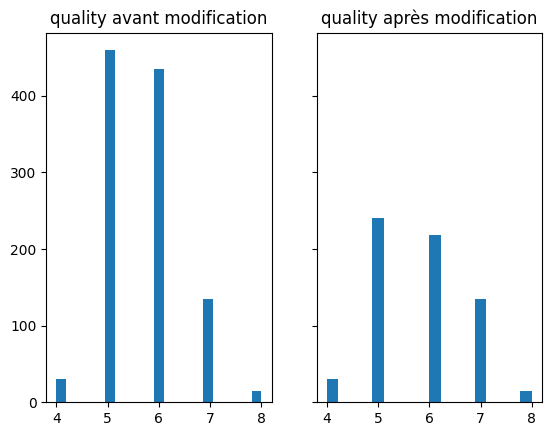

In [7]:
import random
supp=[]
for i in range(len(y)):
    if y[i]==5 or y[i]==6:
        rand=random.random()
        if(rand>0.5):
            supp.append(i)
y2=np.delete(y,supp)

X2=np.delete(X,supp,0)

#Plot des modifications
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(y, bins='auto',label="quality")
ax[0].set_title("quality avant modification")

ax[1].hist(y2, bins='auto',label="quality")
ax[1].set_title("quality après modification")

<b><font color='black' size="5">Création des jeux de tests:
Nous allons pour différents modèles faire de la validation croisée. Nous avons pour cela besoin d'un jeu de données d'entrainement, d'un jeu de validation pour le choix des modèles/hyperparamètres et d'un jeu de test du modèle choisi.</font> </b>


In [9]:
#on créé les jeux de données
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X2, y2, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

print("nombre d'observations X: ",len(X_train))
print("nombre d'observations y: ",len(y_train))

nombre d'observations X:  382
nombre d'observations y:  382


<b><font color='black' size="5">Dernière étape : on normalise tous les jeux</font> </b>

In [10]:
def zscore_normalize_features(X):
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

 # normalize the original features
X_trainN, X_mu, X_sigma = zscore_normalize_features(X_train)
X_cvN, X_mu, X_sigma = zscore_normalize_features(X_cv)
X_testN, X_mu, X_sigma = zscore_normalize_features(X_test)

<b><font color='blue' size="6">b) Première Méthode : Regression Linéaire par moindre carrés avec régularisation:</font> </b>

<b><font color='black' size="5">Nous allons pour cette première méthode traiter la question comme une régression linéaire.
Avec quality = b1*fixe_acidity + b2* volatile_acidity+ ... + b10*sulphates.
On va calculer les coefficients avec cette méthodes pour plusieurs Lambda avec le jeu X_train, puis comparer les résultats en fonction de l'hyperparamètre Lambda sur le jeu X_cv et évaluer finalement notre modèle avec le meilleur Lambda sur le jeu X_test.</font> </b>

In [11]:
from numpy.linalg import inv

def moindre_carrees_regularise(X,y,Lambda):
    X=np.array(X)
    y=np.array(y)
    m=len(X[0])
    rterm=np.matmul(np.transpose(X), y)

    lterm=np.matmul(np.transpose(X),X) + Lambda * np.identity(m)

    beta=np.matmul(inv(lterm),rterm)

    return beta
                     

In [13]:
Lambdas=[0,0.01,1,100]
betas=[]
for loop in range(len(Lambdas)):
    betas.append(moindre_carrees_regularise(X_train,y_train,Lambdas[loop]))
    print("Lambda = ",Lambdas[loop]," et Coefficients = ",betas[loop])

Lambda =  0  et Coefficients =  [-0.60640657 -1.91618945  0.82561506  0.10429171 -0.4463142   0.35798358
 -0.61654138 12.45406683 -0.87769952  1.02876821]
Lambda =  0.01  et Coefficients =  [-0.53126569 -1.83135111  0.84393815  0.10338238 -0.46782707  0.35736888
 -0.60829219 11.67425935 -0.73664043  1.01920231]
Lambda =  1  et Coefficients =  [ 0.43306223 -0.52626748  1.01827944  0.09313845 -0.75516322  0.34491482
 -0.49694017  1.83193726  0.95842441  0.90061192]
Lambda =  100  et Coefficients =  [ 0.51049957  0.10703829  0.23570422  0.04631569 -0.6378667   0.16637771
  0.07941815  0.22239853  0.66924061  0.20537541]


<b><font color='black' size="5">On a trouvé nos coefficients Beta, on va tester nos résultats:</font> </b>

In [82]:
def compute_cost(X, y, beta): 

    m = X.shape[0]
    
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], beta)            #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost
    

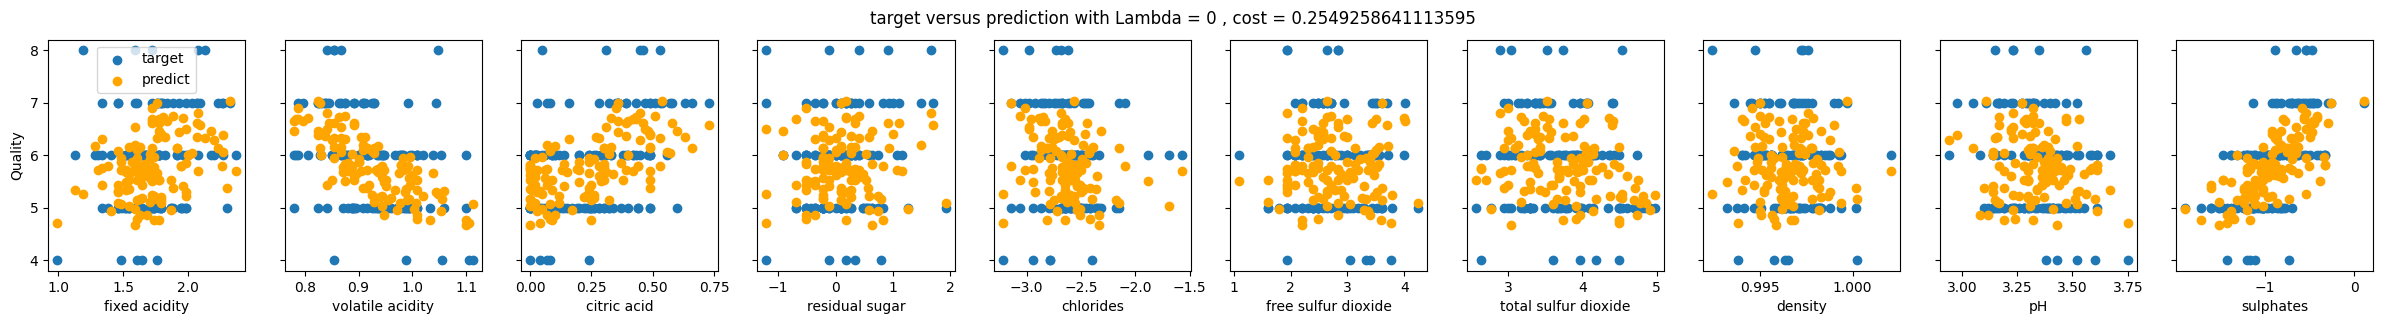

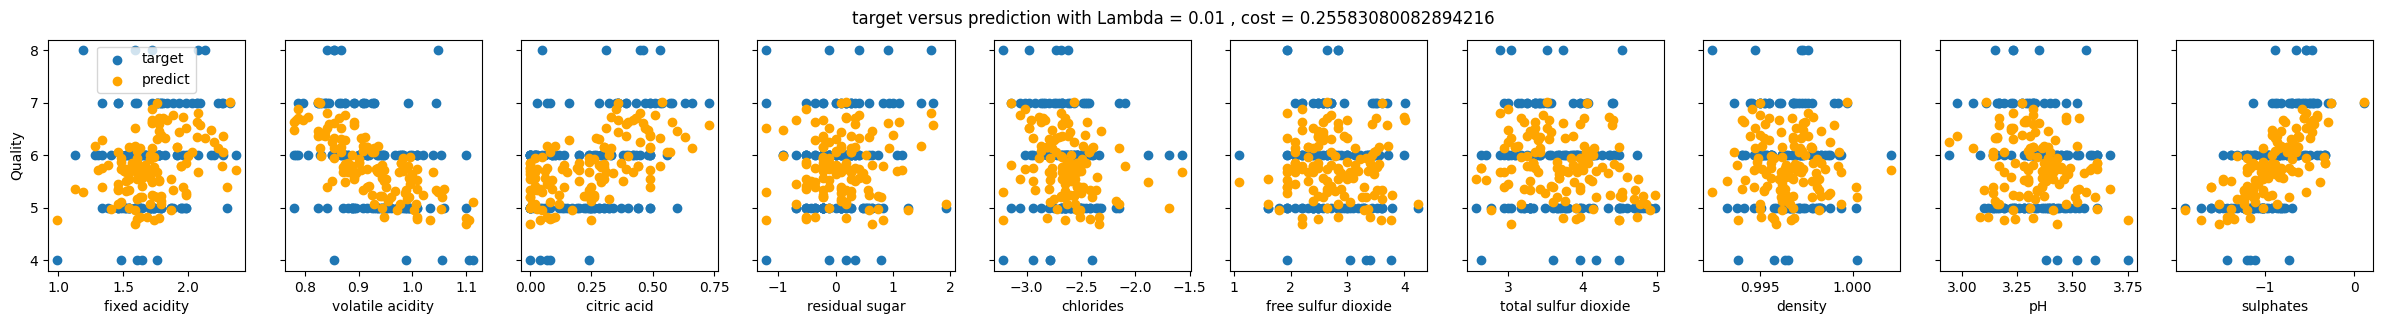

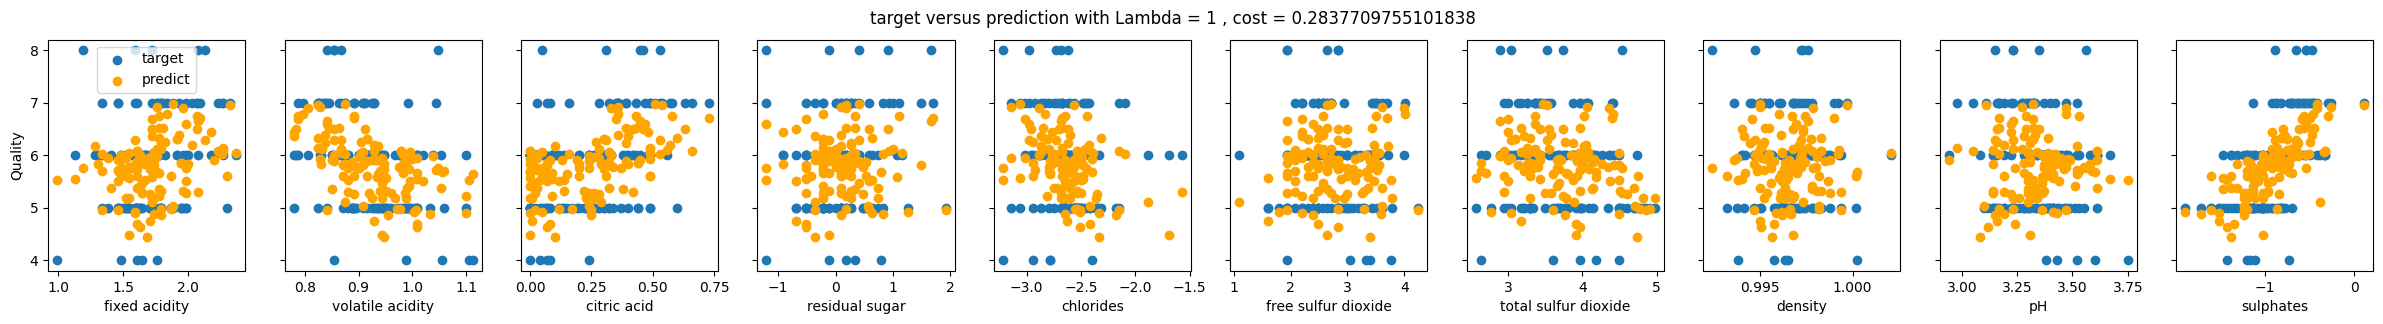

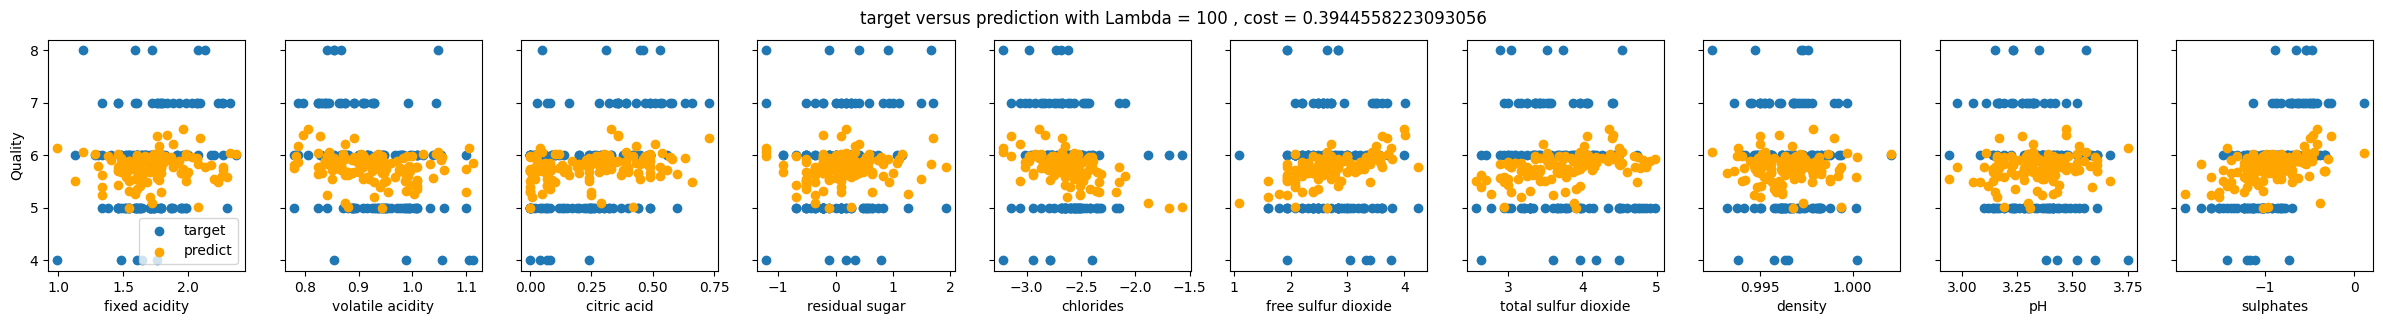

In [83]:
#predict target using normalized features
for loop in range(len(Lambdas)):
    m = X_cv.shape[0]
    yp = np.zeros(m)
    for i in range(m):
        yp[i] = np.dot(X_cv[i], betas[loop])

        # plot predictions and targets versus original features    
    fig,ax=plt.subplots(1,nb_feature,figsize=(30, 3),sharey=True)
    for i in range(len(ax)):
        ax[i].scatter([X_cv[:,i]],y_cv, label = 'target')
        ax[i].set_xlabel(X_features[i])
        ax[i].scatter([X_cv[:,i]],yp,color="orange", label = 'predict')
    ax[0].set_ylabel("Quality"); ax[0].legend()
    title="target versus prediction with Lambda = "+str(Lambdas[loop])+ " , cost = "+ str(compute_cost(X_cv,y_cv,betas[loop]))
    fig.suptitle(title)
    plt.show()

<b><font color='black' size="5">D'après ces tests, on garde lambda = 0, notre modèle n'est pas assez complexe pour nécessiter une régularisation. 
évaluons maintenant le modèle sur le jeu de test.</font> </b>

In [84]:
print("cost final = ", str(compute_cost(X_test,y_test,betas[0])))

cost final =  0.26605026731051534


<b><font color='black' size="5">On a une erreur quadratique moyenne de 0,266. Visuellement le résultat ne parait pas très bon. La régression linéaire n'est pas adaptée car on doit trouver des valeurs discrètes.</font> </b>

<b><font color='blue' size="6">c) Deuxième Méthode: la Descente de Gradient </font> </b>


<b><font color='black' size="5">Pour trouver de nouveau les coefficients de la régression linéaire, nous allons utiliser la méthode de la descente de gradient.
Avec cette fois quality = w1*fixe_acidity + w2* volatile_acidity+ ... + w10*sulphates + b0

Cette méthode actualise de manière itérative les coefficients W et b0 pour minimiser le cout (= l'erreur quadratique moyenne de prédiction).

Elle est moins rapide que la regression précédente mais a l'avantage de pouvoir être utilisée pour n'importe quelle quality = g(W,b) (pas seulement un problème linéaire)
Testons cette méthode d'abord pour une regression linéaire.</font> </b>


<b><font color='orange' size="5">Codes :</font> </b>


In [85]:
import copy
import math


def compute_cost(X, y, w, b): 

    m = X.shape[0]
    
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost

def compute_gradient(X, y, w, b): 

    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                    
        err = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                      
            dj_dw[j] = dj_dw[j] + err * X[i, j]    
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

def gradient_descent(X, y, w_in, b_in, alpha, num_iters): 
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = compute_gradient(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            
           print("Iteration", i,": Cost ", J_history[-1])
        
    return w, b, np.squeeze(J_history) #return final w,b and J history for graphing

<b><font color='black' size="5">Application:</font> </b>

(374, 10)
(374,)
w_init shape: (10,), b_init type: <class 'int'>
test cout :  17.362299465240643
Iteration 0 : Cost  14.08996743622551
Iteration 200 : Cost  0.2443481295063563
Iteration 400 : Cost  0.24423591691349456
Iteration 600 : Cost  0.24423350061681215
Iteration 800 : Cost  0.24423344808600853
Iteration 1000 : Cost  0.24423344694386442
Iteration 1200 : Cost  0.24423344691903137
Iteration 1400 : Cost  0.24423344691849116
Iteration 1600 : Cost  0.24423344691847965
Iteration 1800 : Cost  0.24423344691847904
 Coefficients b,w trouvés: 5.820855614973543,[ 0.28087615 -0.1889504   0.05920374  0.14462724 -0.02675343  0.06247141
 -0.15266377 -0.40236769  0.08360496  0.27332941] 


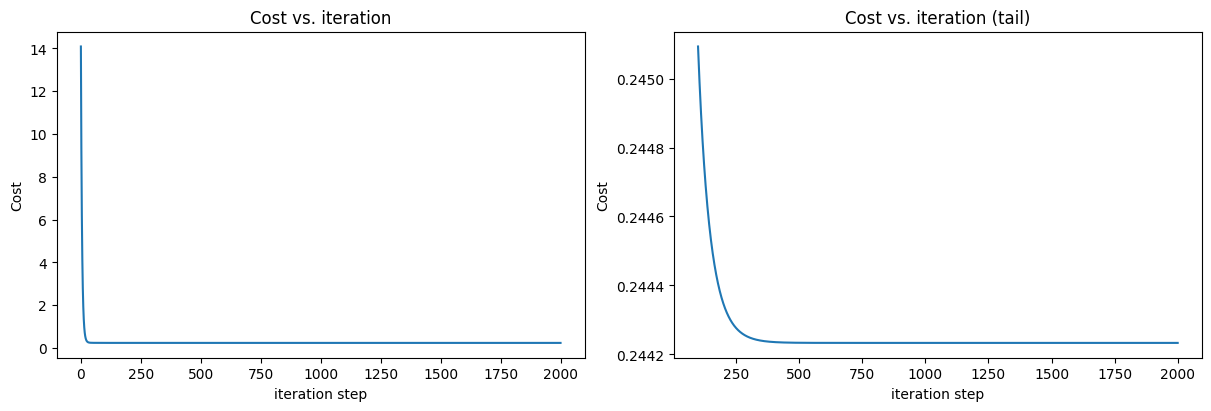

In [87]:
#Paramètres:
b_init = 0
w_init = np.array([ 0,0,0,0,0,0,0,0,0,0])
initial_w = np.zeros_like(w_init)
initial_b = 0.
print(X_trainN.shape)
print(y_train.shape)
#test calcul d'un coût
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")
print("test cout : ",compute_cost(X_trainN, y_train, initial_w, initial_b))

# gradient descent settings
iterations = 2000
alpha =  0.1

# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_trainN, y_train, initial_w, initial_b,alpha, iterations)
print(f" Coefficients b,w trouvés: {b_final},{w_final} ")
m,_ = X_train.shape

# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()



<b><font color='black' size="5">La descente de gradient nous donne les coefficients de la régression linéaire qui minimisent l'erreur.
On voit ci-dessus l'évolution de l'erreur moyenne en fonction de l'itération.</font> </b>

<b><font color='black' size="5">Voyons l'influence de l'Hyperparamètre Alpha :
Alpha est l'hyperparamètre de la descente de gradient qui met à jour les coefficients de la regression à chaque itération. Plus alpha sera grand, plus l'ajustement à chaque itération sera important.</font> </b>

Iteration 0 : Cost  284.0365019780978


/tmp/ipykernel_35587/1263849773.py:22: RuntimeWarning: overflow encountered in double_scalars
  cost = cost + (f_wb_i - y[i])**2       #scalar


Iteration 200 : Cost  inf


/tmp/ipykernel_35587/1263849773.py:46: RuntimeWarning: overflow encountered in double_scalars
  dj_dw[j] = dj_dw[j] + err * X[i, j]


Iteration 400 : Cost  nan
Iteration 600 : Cost  nan
Iteration 800 : Cost  nan
Iteration 1000 : Cost  nan
Iteration 1200 : Cost  nan
Iteration 1400 : Cost  nan
Iteration 1600 : Cost  nan
Iteration 1800 : Cost  nan
Iteration 0 : Cost  17.360575528683576
Iteration 200 : Cost  17.01929376799513
Iteration 400 : Cost  16.6848914508912
Iteration 600 : Cost  16.35722619303301
Iteration 800 : Cost  16.036158762632734
Iteration 1000 : Cost  15.72155299899876
Iteration 1200 : Cost  15.41327573382292
Iteration 1400 : Cost  15.111196715086663
Iteration 1600 : Cost  14.815188533470177
Iteration 1800 : Cost  14.525126551154262


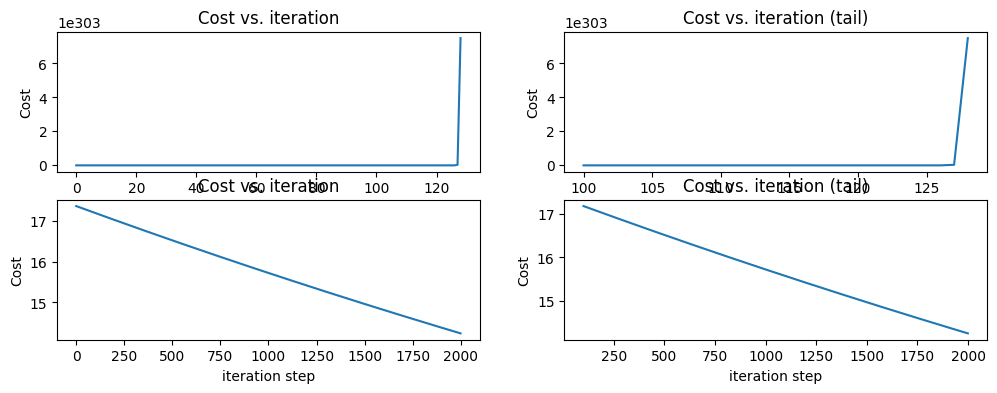

In [88]:
alpha1 = 5.0
alpha2 = 5.0e-5
fig, [[ax1,ax2],[ax3,ax4]]= plt.subplots(nrows=2, ncols=2, figsize=(12, 4))
w_final1, b_final1, J_hist1 = gradient_descent(X_trainN, y_train, initial_w, initial_b,alpha1, iterations)
w_final2, b_final2, J_hist2 = gradient_descent(X_trainN, y_train, initial_w, initial_b,alpha2, iterations)



ax1.plot(J_hist1)
ax2.plot(100 + np.arange(len(J_hist1[100:])), J_hist1[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 

ax3.plot(J_hist2)
ax4.plot(100 + np.arange(len(J_hist2[100:])), J_hist2[100:])
ax3.set_title("Cost vs. iteration");  ax4.set_title("Cost vs. iteration (tail)")
ax3.set_ylabel('Cost')             ;  ax4.set_ylabel('Cost') 
ax3.set_xlabel('iteration step')   ;  ax4.set_xlabel('iteration step') 
plt.show()

<b><font color='black' size="5">Le premier alpha est trop grand, on saute l'optimum. Le second est trop petit, on ne l'atteint qu'après un trop grand nombre d'itérations...</font> </b>

<b><font color='black' size="5">Test du Résultat: Le premier alpha testé est le meilleur trouvé. On a donc nos coefficients permettant de minimiser l'erreur, visualisons les prédictions calculées.</font> </b>

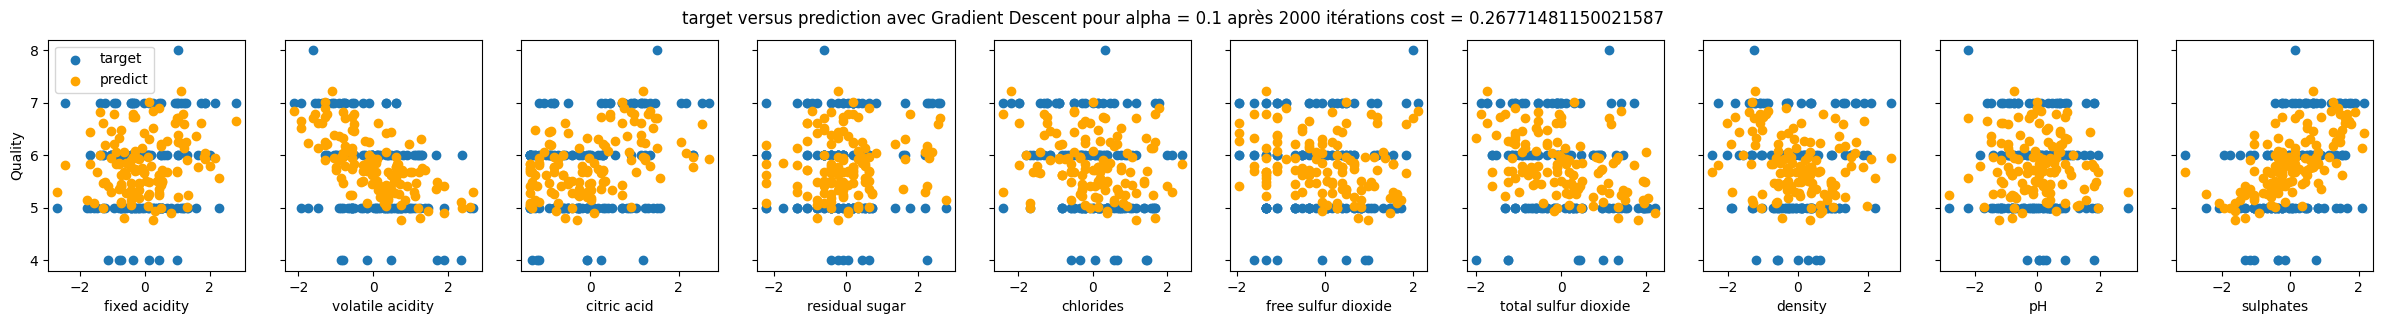

In [91]:
#predict target using normalized features
m = X_cvN.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_testN[i], w_final) + b_final

    # plot predictions and targets versus original features    
fig,ax=plt.subplots(1,nb_feature,figsize=(30, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter([X_testN[:,i]],y_test, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter([X_testN[:,i]],yp,color="orange", label = 'predict')
ax[0].set_ylabel("Quality"); ax[0].legend()
title="target versus prediction avec Gradient Descent pour alpha = 0.1 après 2000 itérations cost = "+ str(compute_cost(X_testN, y_test, w_final, b_final))
fig.suptitle(title)
plt.show()

<b><font color='black' size="5">Le coût est similaire, un petit peu plus élevé. Nous allons maintenant utiliser la méthode de la descente de gradient pour un nouveau type de fonctions qualité = g(W,B)
avec g : un ensemble de fonctions g_y(W,B,x) donnant la probabilité d'appertenance d'un vin x à une qualité y. C'est l'algorithme Softmax.</font> </b>